# Classification with Logistic Regression

# Objectives

- Recognize the model-less baseline understanding for a classification task
- Use logistic regression to perform a classification task

## Set Up

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For our modeling steps
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Your task: predict who will survive the sinking of the Titanic, given the passenger manifest. So we are predicting the column `survived`

Dataset details: https://www.kaggle.com/c/titanic/data

In [2]:
# Getting the data from sklearn
dfX, dfy = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
# Cleaning a bit to get to a full dataframe of the data
df = dfX.copy()
df = df.drop(columns=['boat', 'body', 'home.dest'])
df['survived'] = dfy

df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   name      1309 non-null   object  
 2   sex       1309 non-null   category
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   float64 
 5   parch     1309 non-null   float64 
 6   ticket    1309 non-null   object  
 7   fare      1308 non-null   float64 
 8   cabin     295 non-null    object  
 9   embarked  1307 non-null   category
 10  survived  1309 non-null   category
dtypes: category(3), float64(5), object(3)
memory usage: 86.1+ KB


## Model-Less Baseline

As always, we want to know what we're up against: How hard is our problem? Do we even need to use a model here?

Can we think of a strategy, without modeling, to guess whether a person survives the Titanic?

- 


In [5]:
# Implement the strategy here!
df["survived"].value_counts(normalize=True)

0    0.618029
1    0.381971
Name: survived, dtype: float64

In [6]:
# Create our predictions as something list-like
model_less_preds = ["0"] * len(df)

In [7]:
# Use sklearn's accuracy_score to compare actual to predictions
accuracy_score(df["survived"], model_less_preds)

0.6180290297937356

## Modeling with Logistic Regression!

Let's build our first model! What features should we use?

In [9]:
# Explore the data to decide which columns to start with
df.isna().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
survived       0
dtype: int64

In [10]:
# Define your initial X and y
X = df[["pclass", "sex", "age"]]
y = df["survived"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Preprocessing

Don't forget - SKLearn's implementation of Logistic Regression penalizes coefficients by default - at the very least, we'll need to scale our features!

If we want to use any categorical or object-type columns as input variables, we'll need to encode them. We will also need to deal with any null values in columns we want to use.

[A really useful resource/example of processing the Titanic data!](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

Steps:
- Scale
- Null data in `age`
- Encode `sex`

In [12]:
# Implement preprocessing steps here
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [17]:
numeric_features = ["age"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

categorical_features = ["sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [18]:
preprocessor.fit(X_train)

X_train_pr = preprocessor.transform(X_train)
X_test_pr = preprocessor.transform(X_test)

## Actual Model!

Now that we've preprocessed our data, let's model it!

In [19]:
# Instantiate our logistic regression model
logreg = LogisticRegression()
# Fit our model
logreg.fit(X_train_pr, y_train)

LogisticRegression()

In [20]:
# Evaluate: use .score to check accuracy on train and test
logreg.score(X_train_pr, y_train)

0.7869520897043832

In [21]:
logreg.score(X_test_pr, y_test)

0.7957317073170732

## Interpreting Coefficients

In [22]:
# Check out our coefficients - what do we learn?
logreg.coef_

array([[-0.29218654,  1.21849964, -1.21848316,  1.01409269, -0.04801239,
        -0.96606382]])

## Iterating to Optimize Hyperparameters

We've built an initial model, and now there are a lot of ways we can potentially improve our models. For example, we could use more features, drop less useful features, engineer smarter features, etc.

BUT one thing we haven't explored so far is optimizing hyperparameters! Specifically, we might think about optimizing how strong our regularization parameter - should we penalize our model more? less? 

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [74]:
# Let's use cross_validate to try out different regularization strengths
# I envision this as a for loop, looping over different options for C 
# Don't forget to capture the outputs of each loop somewhere!
C = [1000.0 ,100.01, 10.001, 1.0001, .9001, .8001, .7001, .6001, .5001, .4001, .3001, .2001, .1001, .0501, .0101, .0075, .0052, .0046, .0041, .0039, .0035, .0033, .0031, .0025, .0011, .0005, .0001]
train_score = []
test_score = []
for c in C:
    logreg = LogisticRegression(C=c, random_state=1000)
    logreg.fit(X_train_pr, y_train)
    train_score.append(logreg.score(X_train_pr, y_train))
    test_score.append(logreg.score(X_test_pr, y_test))
print("C      | train score        | test score")
for y, x in enumerate(train_score):
    print(C[y],"|", train_score[y], "|", test_score[y])
    

C      | train score        | test score
1000.0 | 0.7869520897043832 | 0.7957317073170732
100.01 | 0.7869520897043832 | 0.7957317073170732
10.001 | 0.7869520897043832 | 0.7957317073170732
1.0001 | 0.7869520897043832 | 0.7957317073170732
0.9001 | 0.7869520897043832 | 0.7957317073170732
0.8001 | 0.7869520897043832 | 0.7957317073170732
0.7001 | 0.7869520897043832 | 0.7957317073170732
0.6001 | 0.7869520897043832 | 0.7957317073170732
0.5001 | 0.7869520897043832 | 0.7957317073170732
0.4001 | 0.7869520897043832 | 0.7957317073170732
0.3001 | 0.7859327217125383 | 0.7957317073170732
0.2001 | 0.7859327217125383 | 0.7926829268292683
0.1001 | 0.7849133537206932 | 0.7926829268292683
0.0501 | 0.7828746177370031 | 0.7926829268292683
0.0101 | 0.7961264016309888 | 0.7408536585365854
0.0075 | 0.7961264016309888 | 0.7469512195121951
0.0052 | 0.7686034658511722 | 0.7195121951219512
0.0046 | 0.7471967380224261 | 0.6859756097560976
0.0041 | 0.7308868501529052 | 0.6585365853658537
0.0039 | 0.7206931702344547 

In [75]:
y_train.value_counts(normalize=True)

0    0.637105
1    0.362895
Name: survived, dtype: float64

In [76]:
y_test.value_counts(normalize=True)

0    0.560976
1    0.439024
Name: survived, dtype: float64

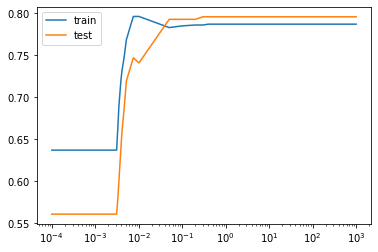

In [77]:
# Explore our results
fig, ax = plt.subplots()
plt.xscale('log')
ax.plot(C, train_score, label='train')
ax.plot(C, test_score, label='test')
plt.legend();

In [ ]:
# Build a new model with the best regularization strength, on the full train set


In [ ]:
# Then evaluate on train and test


#### Discuss!

- 


----

## Level Up: Notes on Cost Functions, and Solutions To the Optimization Problem

Unlike the least-squares problem for linear regression, no one has yet found a closed-form solution to the optimization problem presented by logistic regression. But even if one exists, the computation would no doubt be so complex that we'd be better off using some sort of approximation method instead.

But there's still a problem.

Recall the cost function for linear regression: <br/><br/>
$SSE = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i(y_i - (\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in}))^2$.

This function, $SSE(\vec{\beta})$, is convex.

If we plug in our new logistic equation for $\hat{y}$, we get: <br/><br/>
$SSE_{log} = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i\left(y_i - \left(\frac{1}{1+e^{-(\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in})}}\right)\right)^2$.

### The Bad News

*This* function, $SSE_{log}(\vec{\beta})$, is [**not** convex](https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c).

That means that, if we tried to use gradient descent or some other approximation method that looks for the minimum of this function, we could easily find a local rather than a global minimum.

> Note that the scikit-learn class *expects the user to specify the solver* to be used in calculating the coefficients. The default solver, [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS), works well for many applications.

### The Good News

We can use **log-loss** instead:

$\mathcal{L}(\vec{y}, \hat{\vec{y}}) = -\frac{1}{N}\Sigma^N_{i=1}\left(y_iln(\hat{y}_i)+(1-y_i)ln(1-\hat{y}_i)\right)$,

where $\hat{y}_i$ is the probability that $(x_{i1}, ... , x_{in})$ belongs to **class 1**.

**More resources on the log-loss function**:

https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

### 🧠 Knowledge Check

- Is a bigger value (more positive) better or worse than a smaller value?

- What would the log-loss for one data point when the target is $0$ but we predict $1$?

- What would the log-loss for one data point when the target is $0$ but we predict $0$?

## Level Up: More on Interpreting Logistic Regression Coefficients

In [ ]:
logreg.coef_

How do we interpret the coefficients of a logistic regression? For a linear regression, the situaton was like this:

- Linear Regression: We construct the best-fit line and get a set of coefficients. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change in $y$.

- Logistic Regression: We find the coefficients of the best-fit line by some approximation method. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change (not in $y$ but) in $ln\left(\frac{y}{1-y}\right)$.

We have:

$\ln\left(\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}\right) = \ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k$.

Exponentiating both sides:

$\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)} = e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k}$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right)}\cdot e^k$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^k\cdot\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}$

That is, the odds ratio at $x_1+1$ has increased by a factor of $e^k$ relative to the odds ratio at $x_1$.

For more on interpretation, see [this page](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/).

## Level UP:  Other Link Functions, Other Models

Logistic regression's link function is the logit function, but different sorts of models use different link functions.

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) has a nice table of generalized linear model types and their associated link functions.